# **Step 1: Setup & Dataset Load**

In [1]:
#req. packages
!pip install scikit-learn streamlit pyngrok --quiet

#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from datetime import datetime

#loading the csv dataset
df = pd.read_csv("online_retail.csv", encoding="ISO-8859-1")
df.head()
df.info()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 72.3 MB/s eta 0:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# **Step 2: Data Preprocessing**

In [2]:
#removing missing CustomerID
df=df.dropna(subset=['CustomerID'])
#removing cancelled invoices (InvoiceNo starting with 'C')
df=df[~df['InvoiceNo'].astype(str).str.startswith('C')]
#removing negative or zero quantities/prices
df=df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
#creating TotalPrice=Quantity * UnitPrice
df['TotalPrice']=df['Quantity'] * df['UnitPrice']
#converting InvoiceDate to datetime
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


# **Step 3: Exploratory Data Analysis (EDA)**

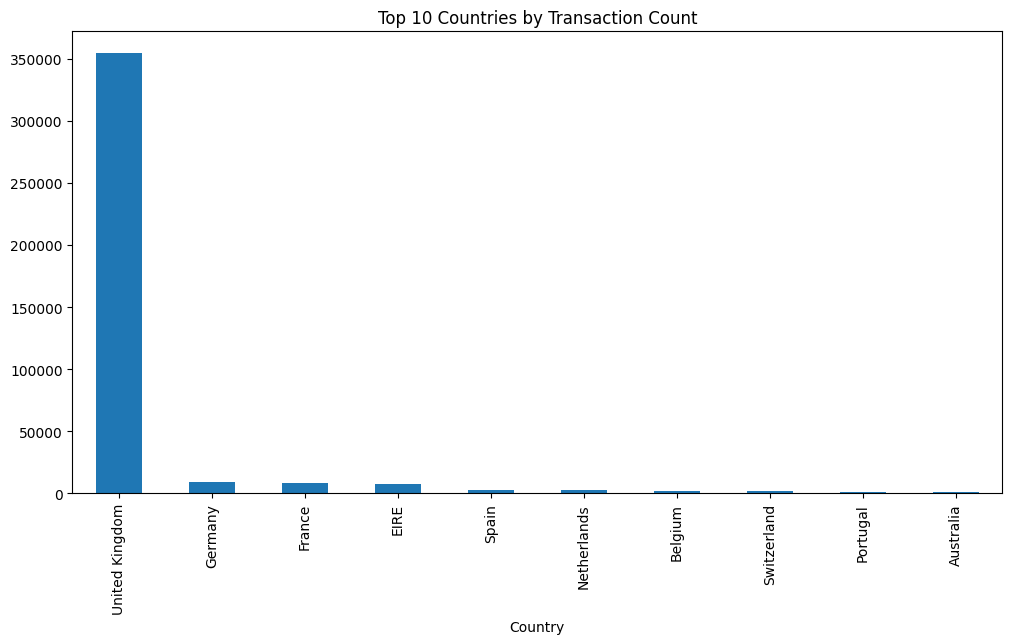

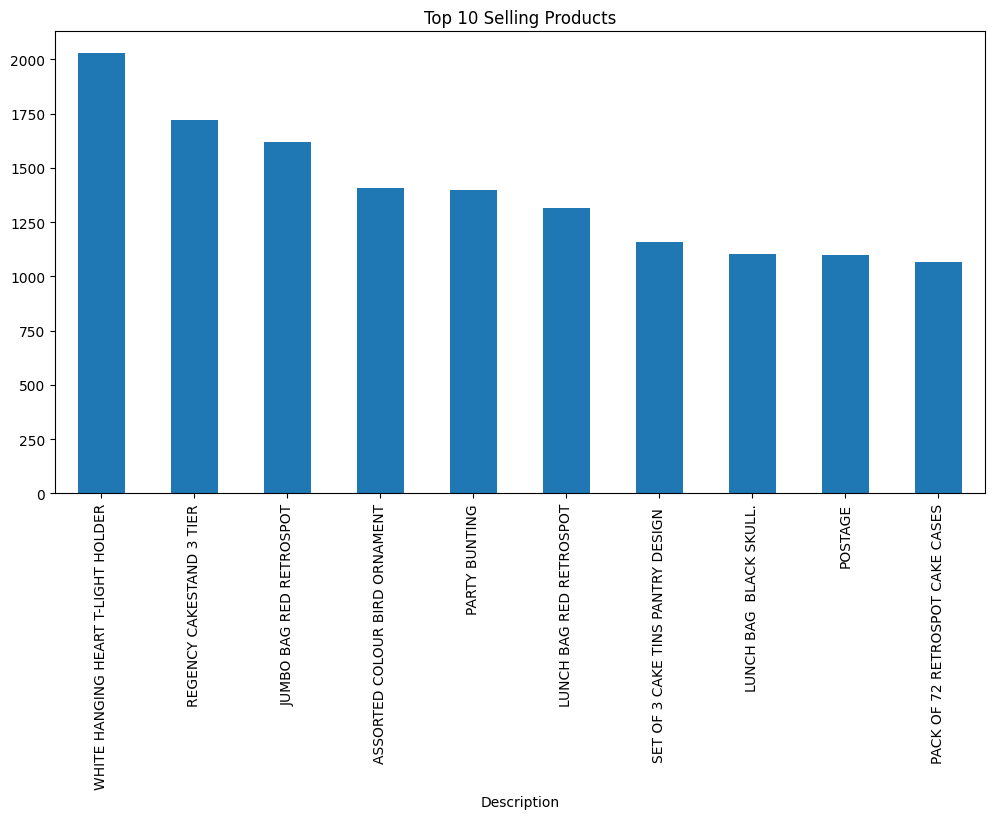

/tmp/ipython-input-2900409578.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('InvoiceDate').resample('M')['InvoiceNo'].count().plot(figsize=(12,6))


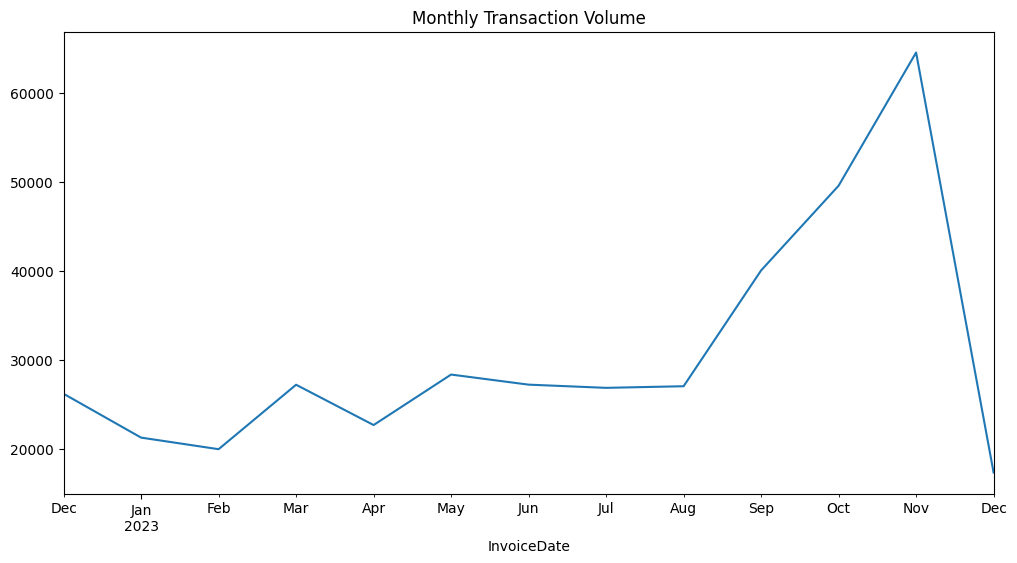

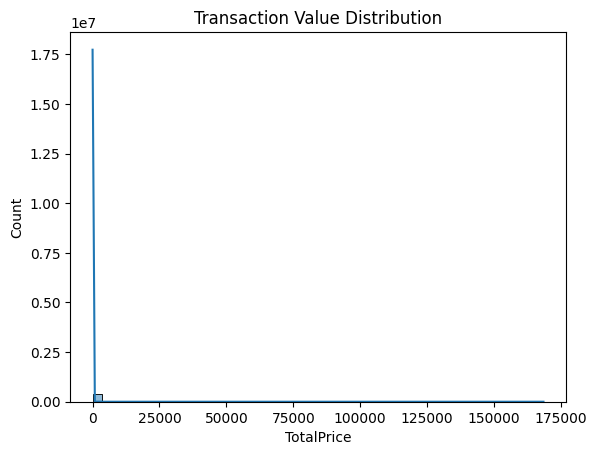

In [3]:
#Transactions per country
plt.figure(figsize=(12,6))
df['Country'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Countries by Transaction Count")
plt.show()

#Top selling products
plt.figure(figsize=(12,6))
df['Description'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Selling Products")
plt.show()

#Purchases over time
df.set_index('InvoiceDate').resample('M')['InvoiceNo'].count().plot(figsize=(12,6))
plt.title("Monthly Transaction Volume")
plt.show()

#Distribution of TotalPrice per transaction
sns.histplot(df['TotalPrice'], bins=50, kde=True)
plt.title("Transaction Value Distribution")
plt.show()

# **Step 4: RFM Feature Engineering**

In [4]:
#Reference date(latest date in dataset)
ref_date=df['InvoiceDate'].max()
#RFM calculation
rfm=df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date-x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns=['CustomerID','Recency','Frequency','Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40


# **Step 5: Clustering**

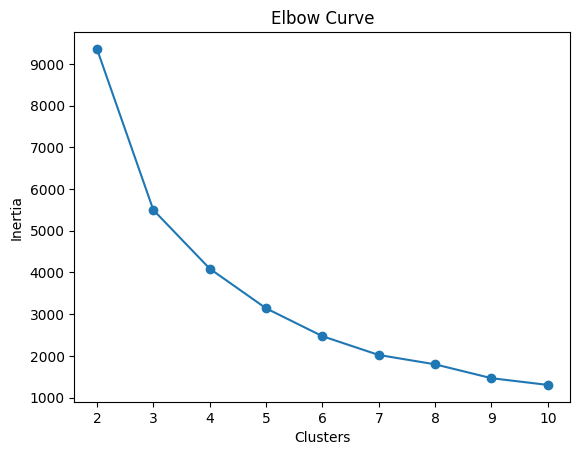

,Recency,Frequency,Monetary
Cluster,,,
0,42.702685,3.682711,1359.049284
1,247.075914,1.552015,480.617480
2,6.384615,82.538462,127338.313846
3,14.500000,22.333333,12709.090490


In [5]:
#Scale RFM
scaler=StandardScaler()
rfm_scaled=scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

#Elbow Method
inertia=[]
for k in range(2,11):
    kmeans=KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2,11), inertia, marker='o')
plt.title("Elbow Curve")
plt.xlabel("Clusters")
plt.ylabel("Inertia")
plt.show()

#Choose k=4 (common in RFM) and run clustering
kmeans=KMeans(n_clusters=4, random_state=42)
rfm['Cluster']=kmeans.fit_predict(rfm_scaled)

#Cluster profiling
rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean()

# **Step 6: Segment Naming**

In [6]:
#Map clusters→segment names
cluster_map={
    0: "High-Value",
    1: "Regular",
    2: "Occasional",
    3: "At-Risk"
}
rfm['Segment']=rfm['Cluster'].map(cluster_map)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster,Segment
0,12346.0,325,1,77183.60,3,At-Risk
1,12347.0,1,7,4310.00,0,High-Value
2,12348.0,74,4,1797.24,0,High-Value
3,12349.0,18,1,1757.55,0,High-Value
4,12350.0,309,1,334.40,1,Regular


# **Step 7: Collaborative Filtering (Product Recommendations)**

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
#creating customer-product matrix
cust_prod=df.pivot_table(index='CustomerID', columns='Description', values='Quantity', fill_value=0)
#cosine similarity between products
product_similarity=cosine_similarity(cust_prod.T)
product_similarity_df=pd.DataFrame(product_similarity,
                                     index=cust_prod.columns,
                                     columns=cust_prod.columns)

def recommend_products(product_name, n=5):
    if product_name not in product_similarity_df.columns:
        return ["Product not found"]
    similar = product_similarity_df[product_name].sort_values(ascending=False)[1:n+1]
    return list(similar.index)
#an example
recommend_products("WHITE HANGING HEART T-LIGHT HOLDER")

['GIN + TONIC DIET METAL SIGN',
 'TEA TIME TEA TOWELS ',
 'FAIRY CAKE FLANNEL ASSORTED COLOUR',
 'DOORMAT FAIRY CAKE',
 'RED HANGING HEART T-LIGHT HOLDER']

# **Step 8: Save Model for Streamlit**

In [8]:
import joblib
joblib.dump(kmeans, "rfm_kmeans.pkl")
joblib.dump(scaler, "scaler.pkl")
product_similarity_df.to_pickle("product_similarity.pkl")